In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [2]:
WORK_DIR = "C:\\Users\\berki\\OneDrive\\Desktop\\ITU_CS\\ComputerVision\\cassava_leaf_disease"
LABEL_MAP_FILE = os.path.join(WORK_DIR, "label_num_to_disease_map.json")
TRAIN_FILE = os.path.join(WORK_DIR, "train.csv")
TRAIN_IMAGES_DIR = os.path.join(WORK_DIR, "train_images")


In [4]:
# Count the total number of image files in the TRAIN_IMAGES_DIR
image_files = [file for file in os.listdir(TRAIN_IMAGES_DIR) if os.path.isfile(os.path.join(TRAIN_IMAGES_DIR, file))]
print(f"Total number of training images: {len(image_files)}")


Total number of training images: 21397


In [5]:
# Load the class labels from label_num_to_disease_map.json
with open(LABEL_MAP_FILE, 'r') as file:
    label_map = json.load(file)

# Print the class list
print("Class list from label_num_to_disease_map.json:")
for label, class_name in label_map.items():
    print(f"Label {label}: {class_name}")


Class list from label_num_to_disease_map.json:
Label 0: Cassava Bacterial Blight (CBB)
Label 1: Cassava Brown Streak Disease (CBSD)
Label 2: Cassava Green Mottle (CGM)
Label 3: Cassava Mosaic Disease (CMD)
Label 4: Healthy


In [35]:
train_data = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_data.head(10)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

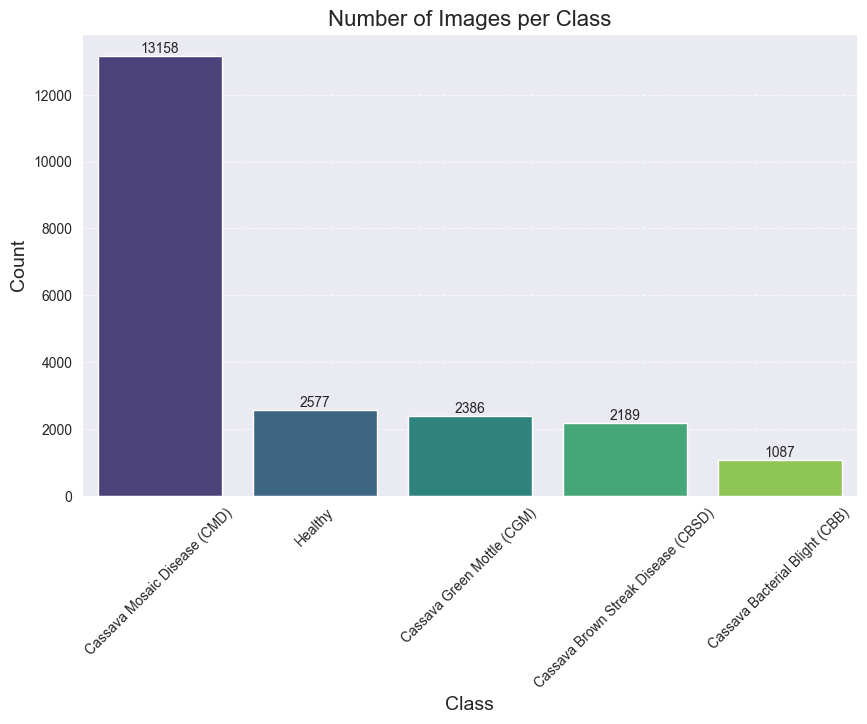

In [7]:


# Dosya yollarını tanımlayın
WORK_DIR = "C:\\Users\\berki\\OneDrive\\Desktop\\ITU_CS\\ComputerVision\\cassava_leaf_disease"
LABEL_MAP_FILE = os.path.join(WORK_DIR, "label_num_to_disease_map.json")
TRAIN_FILE = os.path.join(WORK_DIR, "train.csv")

# Veriyi yükleme
train_data = pd.read_csv(TRAIN_FILE)

# Etiketlerin anlamlarını yükleme ve anahtarları tam sayıya dönüştürme
with open(LABEL_MAP_FILE, 'r') as file:
    label_map = {int(k): v for k, v in json.load(file).items()}

# Sınıf etiketlerini sınıf isimlerine eşleme
train_data['class_name'] = train_data['label'].map(label_map)

# Her sınıftaki görsel sayısını hesaplama
class_counts = train_data['class_name'].value_counts()
# Updated bar chart with counts
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts above bars
for i, count in enumerate(class_counts.values):
    barplot.text(i, count + 100, str(count), ha='center', fontsize=10)

plt.show()



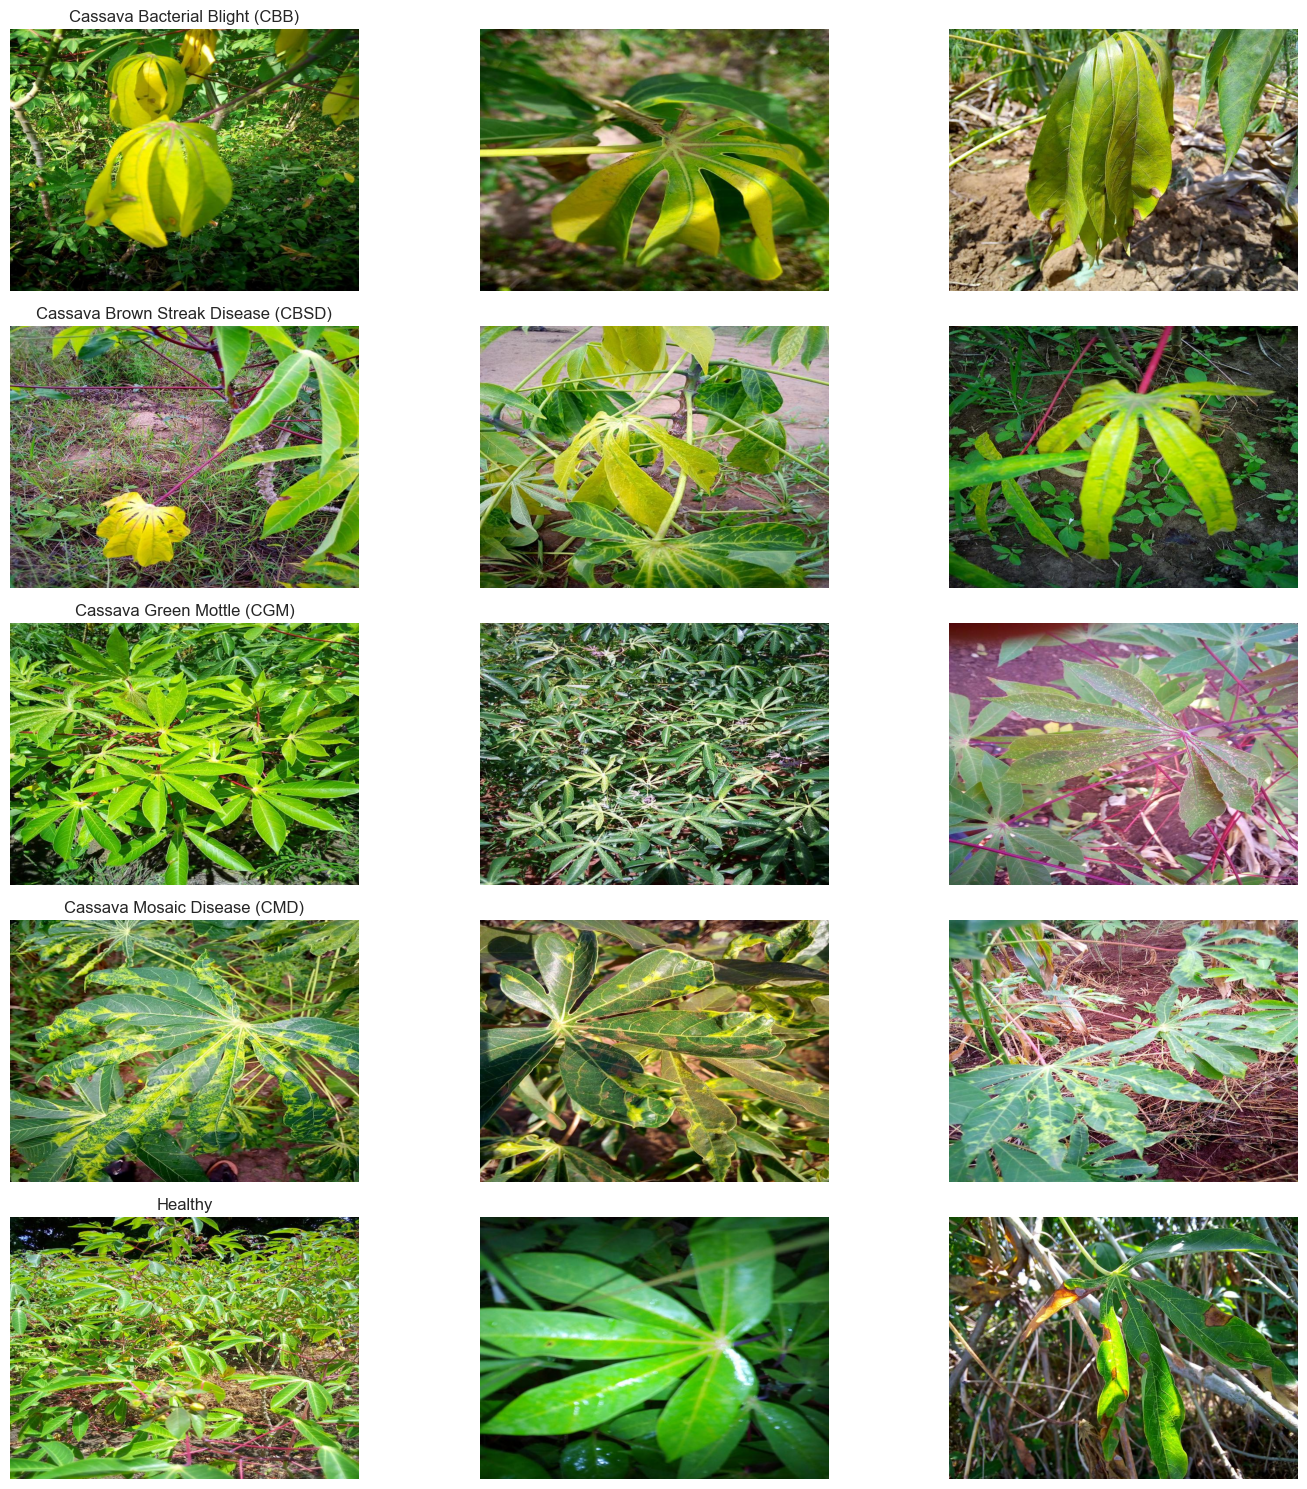

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Number of examples per class
examples_per_class = 3

# Group images by class and sample
sampled_images = train_data.groupby('label').apply(
    lambda x: x.sample(n=examples_per_class, random_state=42)
).reset_index(drop=True)

# Plotting the images
fig, axes = plt.subplots(len(label_map), examples_per_class, figsize=(15, 15))

for i, (label, group) in enumerate(sampled_images.groupby('label')):
    class_name = label_map[label]
    for j, (_, row) in enumerate(group.iterrows()):
        img_path = os.path.join(TRAIN_IMAGES_DIR, row['image_id'])
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=12)

plt.tight_layout()
plt.show()


In [36]:
# Main parameters
BATCH_SIZE = 8
STEPS_PER_EPOCH = int(len(train_data)*0.8 / BATCH_SIZE)
VALIDATION_STEPS = int(len(train_data)*0.2 / BATCH_SIZE)
EPOCHS = 20
TARGET_SIZE = 512


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure labels are strings
train_data['label'] = train_data['label'].astype('str')

# ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=None,  # Add a preprocessing function if needed (e.g., tf.keras.applications.efficientnet.preprocess_input)
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    shear_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1
)

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_IMAGES_DIR,
    subset="training",
    x_col="image_id",
    y_col="label",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

# ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(validation_split=0.2)

# Validation data generator
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_IMAGES_DIR,
    subset="validation",
    x_col="image_id",
    y_col="label",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)


Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


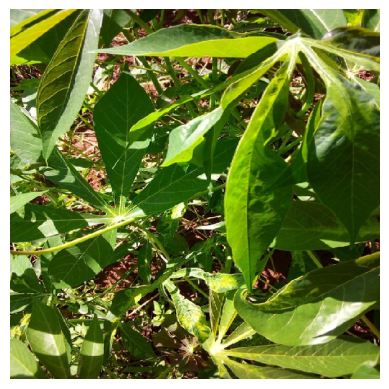

In [17]:
img_path = os.path.join(WORK_DIR, "train_images", train_data.image_id[50])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

Found 1 validated image filenames belonging to 1 classes.


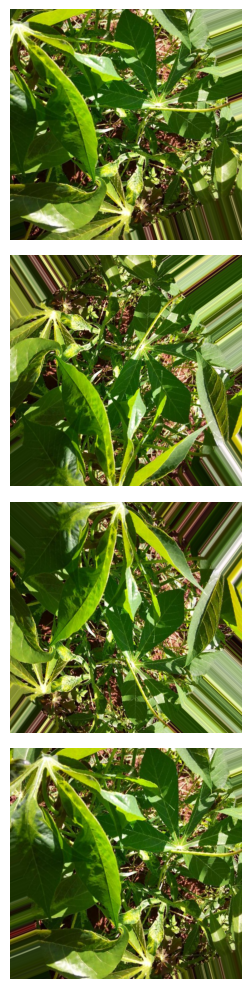

In [18]:
generator = train_datagen.flow_from_dataframe(train_data.iloc[50:51],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(4, 1, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [45]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [46]:
model = create_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 512, 512,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 512, 512,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 513, 513,  │          0 │ normalization_3[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 256, 256,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 256, 256,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 256, 256,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 256, 256,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 256, 256,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 256, 256,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 256, 256,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 256, 256,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 256, 256,  │         64 │ block1a_project_

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [47]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


In [48]:
model.load_weights('C:\\Users\\berki\\OneDrive\\Desktop\\ITU_CS\\ComputerVision\\cassava_leaf_disease\\archive\\basic_EfNetB0_imagenet_512.h5')

In [49]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.weights.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
  53/2139 ━━━━━━━━━━━━━━━━━━━━ 3:17:17 6s/step - acc: 0.5388 - loss: 1.1908

KeyboardInterrupt: 

Epoch 1/20


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 512, 512, 3)